In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.3.0


In [2]:
batch_size = 32
seq_len = 64

d_k = 128
d_v = 128
n_heads = 6
ff_dim = 128

In [3]:
data_set = 'Entrenamiento.csv'

df = pd.read_csv(data_set, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
10068,2020.08.07 23:30,0.71570,0.71584,0.71569,0.71580,46
10069,2020.08.07 23:35,0.71581,0.71582,0.71577,0.71579,37
10070,2020.08.07 23:40,0.71572,0.71574,0.71566,0.71570,42
10071,2020.08.07 23:45,0.71571,0.71583,0.71568,0.71581,64
10072,2020.08.07 23:50,0.71585,0.71611,0.71579,0.71599,96


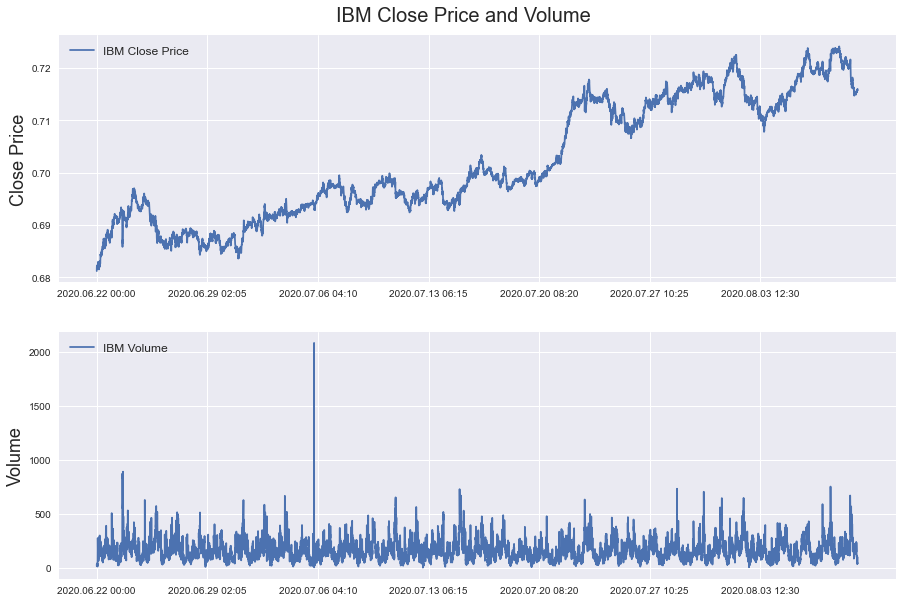

In [4]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [5]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (8058, 5)
Validation data shape: (1007, 5)
Test data shape: (1007, 5)


,Open,High,Low,Close,Volume
1,0.541179,0.642936,0.539588,0.642936,0.089898
2,0.642936,0.509367,0.628627,0.504603,0.017377
3,0.504603,0.533190,0.518898,0.537955,0.083284
4,0.531602,0.509367,0.522073,0.509367,0.016408
5,0.515719,0.522070,0.493487,0.501428,0.080969


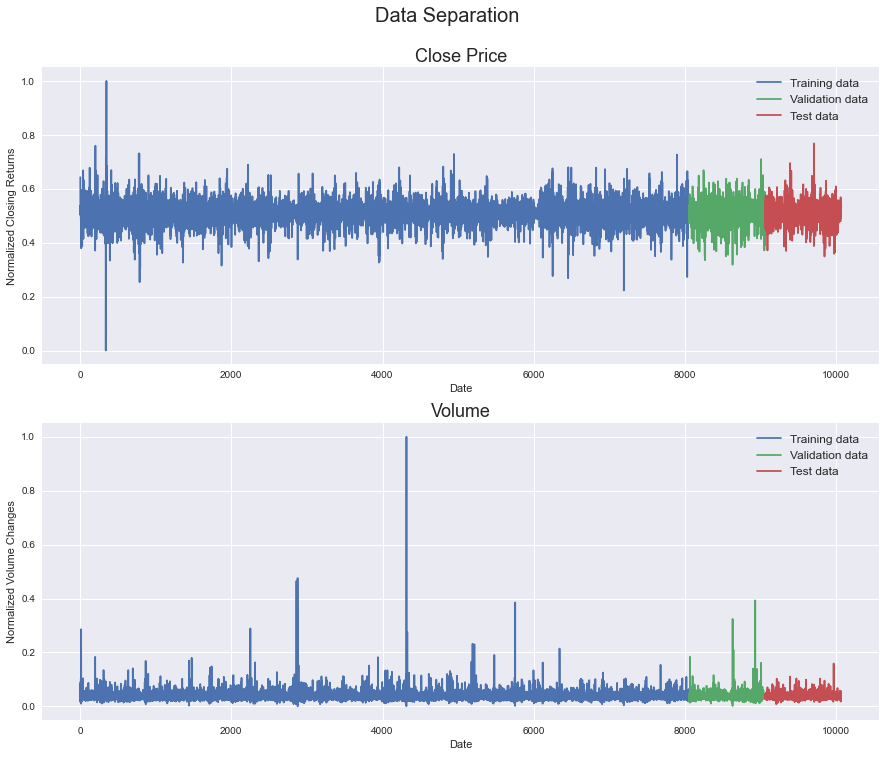

In [6]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [7]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (7994, 64, 5) (7994,)
Validation set shape (943, 64, 5) (943,)
Testing set shape (943, 64, 5) (943,)


In [8]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [9]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 64, 2)        256         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 7)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 64, 7)        25770       concatenate[0][0]     

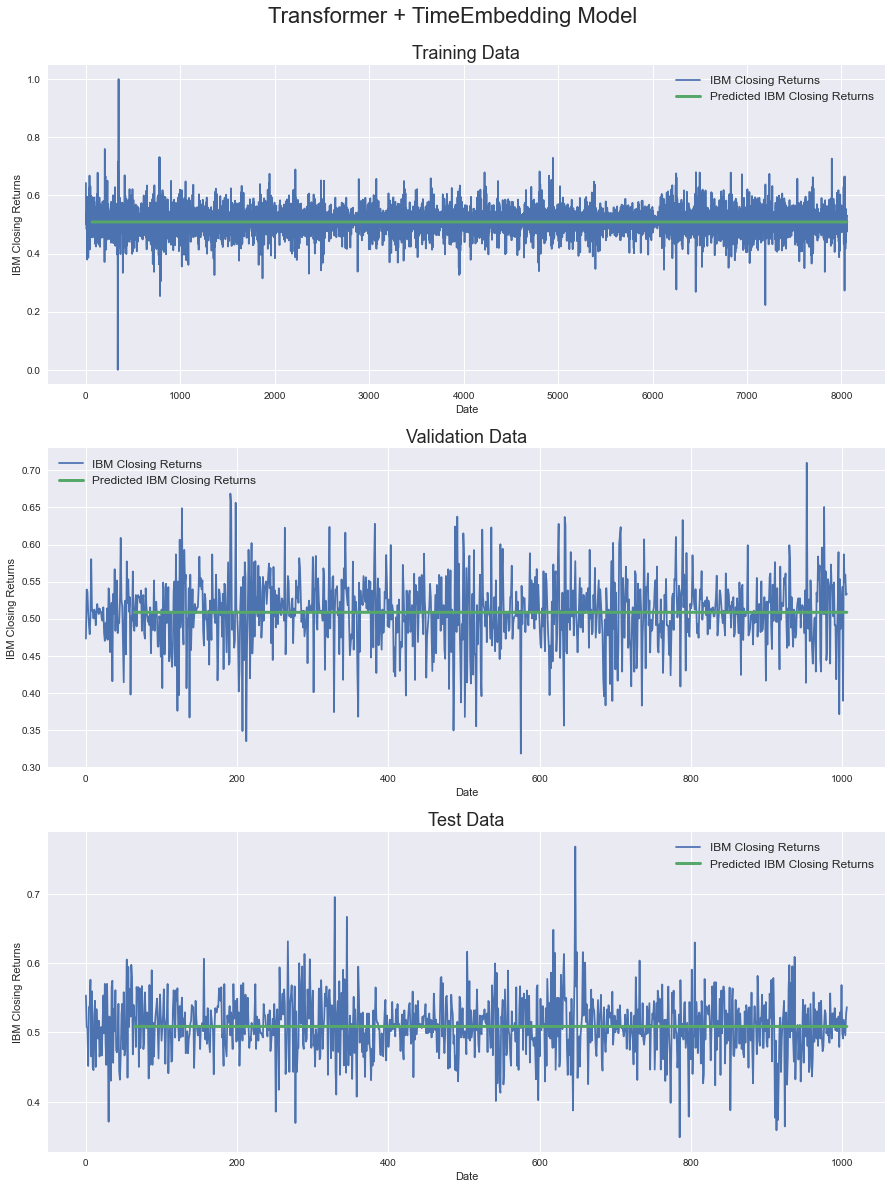

In [10]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

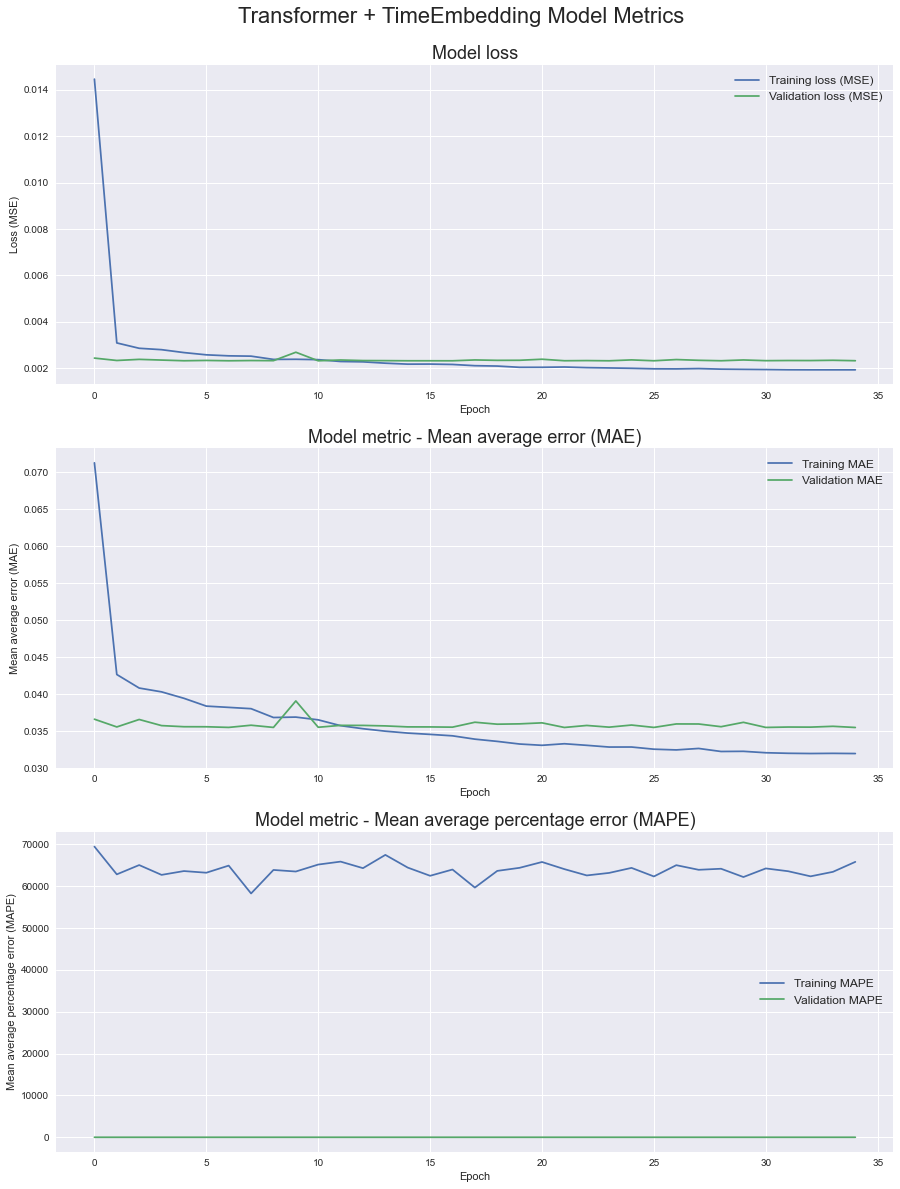

In [11]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [12]:
data_set = 'Entrenamiento.csv'

df = pd.read_csv(data_set, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

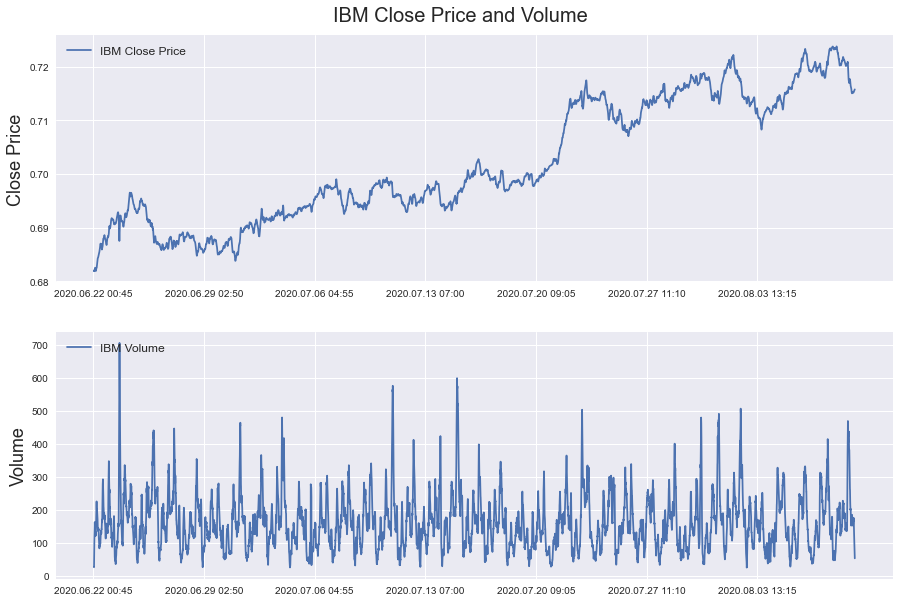

In [13]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [14]:

'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (8051, 5)
Validation data shape: (1006, 5)
Test data shape: (1006, 5)


,Open,High,Low,Close,Volume
10,0.577927,0.577095,0.577934,0.575459,0.231741
11,0.575461,0.531982,0.565622,0.518858,0.233710
12,0.518857,0.577911,0.512293,0.561512,0.471741
13,0.561513,0.554944,0.447478,0.479488,0.366330
14,0.484407,0.504099,0.466339,0.480304,0.294437


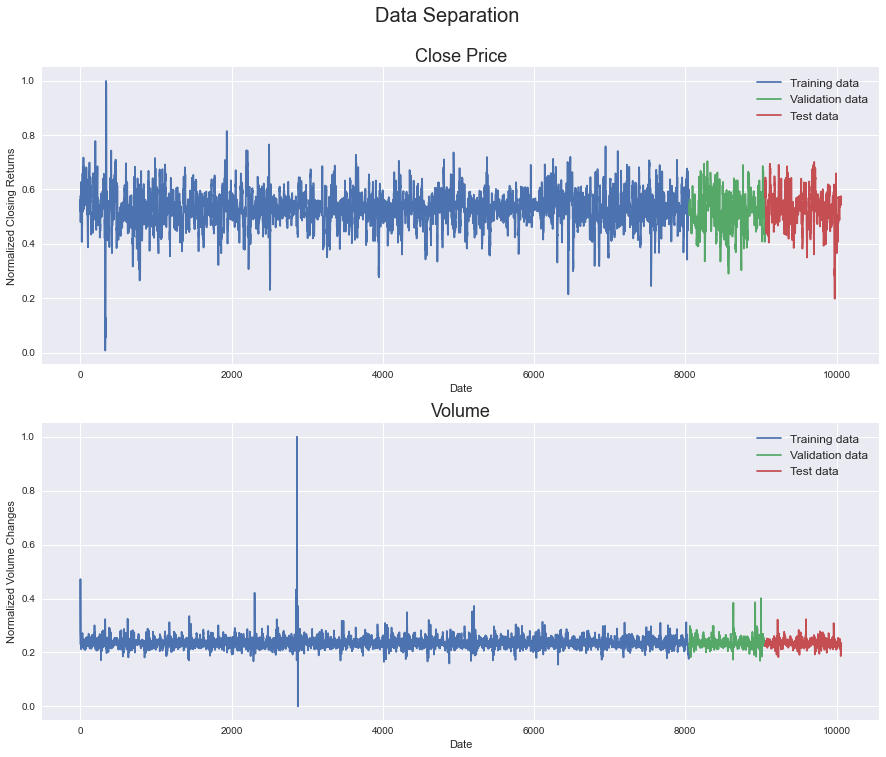

In [15]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [16]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7987, 64, 5) (7987,)
(942, 64, 5) (942,)


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 64, 2)        256         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64, 7)        0           input_2[0][0]                    
                                                                 time2_vector_2[0][0]             
__________________________________________________________________________________________________
transformer_encoder_6 (Transfor (None, 64, 7)        25770       concatenate_1[0][0]   

Epoch 15/35
250/250 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0354 - mape: 7.7722
Epoch 00015: val_loss improved from 0.00207 to 0.00144, saving model to Transformer+TimeEmbedding.hdf5
250/250 [==============================] - 84s 334ms/step - loss: 0.0022 - mae: 0.0354 - mape: 7.7722 - val_loss: 0.0014 - val_mae: 0.0292 - val_mape: 5.8267
Epoch 16/35
250/250 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0332 - mape: 7.1800
Epoch 00016: val_loss did not improve from 0.00144
250/250 [==============================] - 83s 332ms/step - loss: 0.0019 - mae: 0.0332 - mape: 7.1800 - val_loss: 0.0019 - val_mae: 0.0345 - val_mape: 6.8446
Epoch 17/35
250/250 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0312 - mape: 6.6610
Epoch 00017: val_loss did not improve from 0.00144
250/250 [==============================] - 83s 332ms/step - loss: 0.0017 - mae: 0.0312 - mape: 6.6610 - val_loss: 0.0027 - val_mae: 0.0429 - val_mape: 8.4806


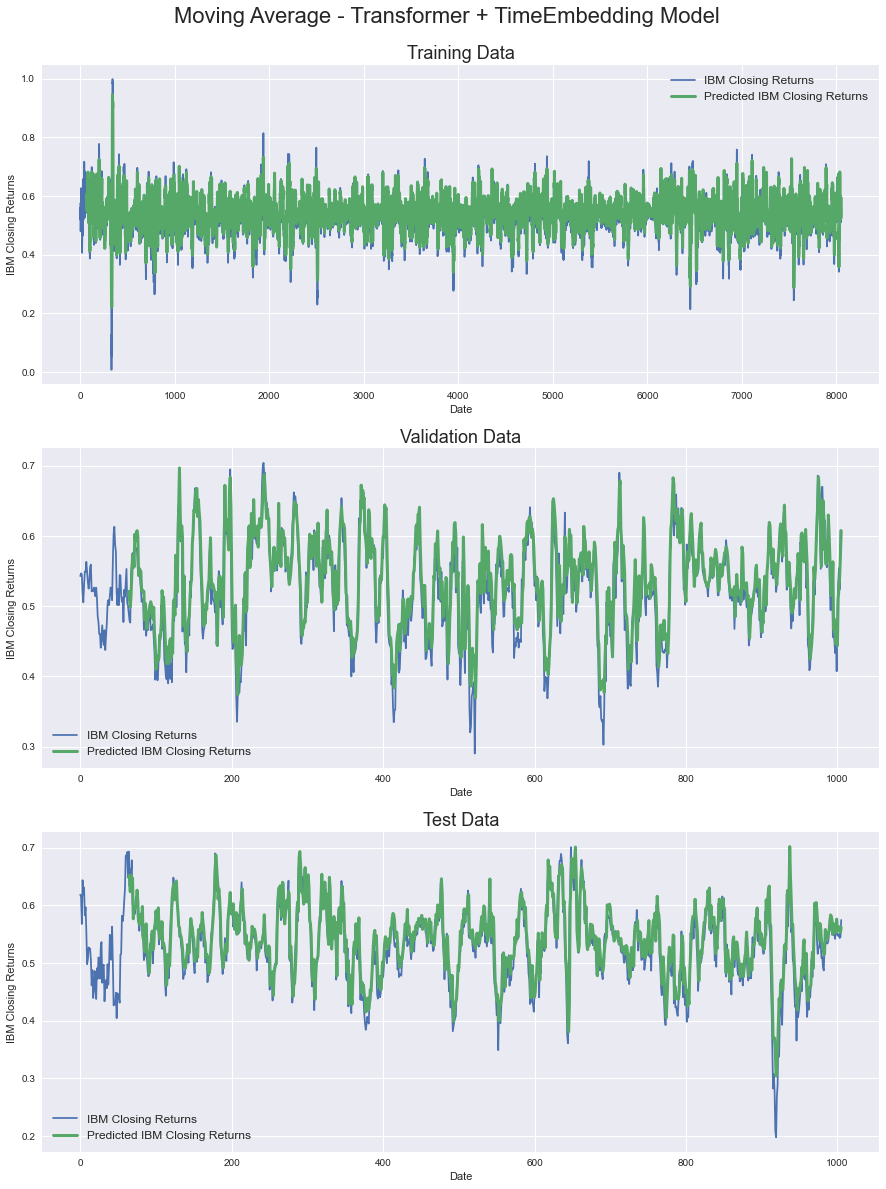

In [17]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

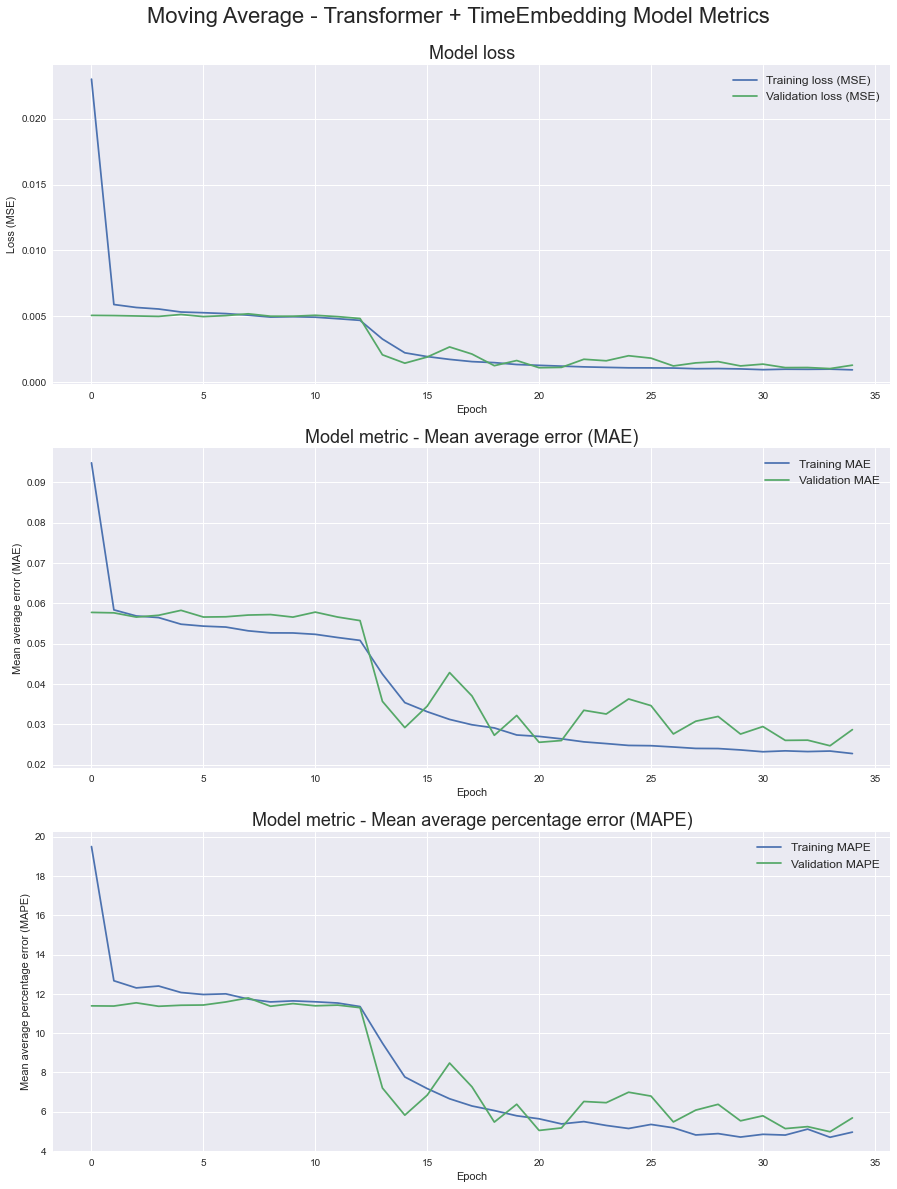

In [18]:

'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [19]:
print(train_pred)

[[0.5977808 ]
 [0.60525805]
 [0.57158077]
 ...
 [0.57283616]
 [0.5676538 ]
 [0.526392  ]]


In [10]:
model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


In [11]:
dataSet = 'Test.csv'

df = pd.read_csv(dataSet, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()


,Date,Open,High,Low,Close,Volume
9,2020.08.10 00:45,0.715703,0.715863,0.715509,0.715652,120.3
10,2020.08.10 00:50,0.715664,0.715820,0.715466,0.715596,124.1
11,2020.08.10 00:55,0.715616,0.715755,0.715466,0.715590,111.6
12,2020.08.10 01:00,0.715598,0.715731,0.715457,0.715591,81.2
13,2020.08.10 01:05,0.715596,0.715723,0.715462,0.715597,82.7


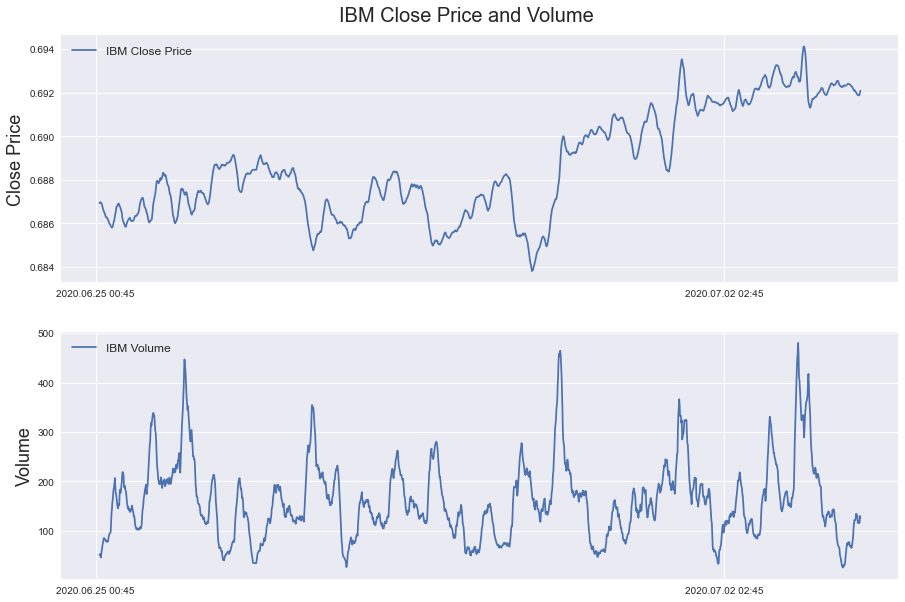

In [534]:

fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [535]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)


###############################################################################
'''Create training, validation and test split'''


df_test = df[(df.index >= 0)]

# Remove date column

df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays

test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (8763, 5)
Validation data shape: (1095, 5)
Test data shape: (1772, 5)


,Open,High,Low,Close,Volume
10,0.588448,0.592614,0.587058,0.599552,0.350039
11,0.598858,0.595389,0.591916,0.592612,0.319077
12,0.592612,0.598858,0.611352,0.615515,0.326424
13,0.616209,0.600940,0.598858,0.587754,0.284781
14,0.584284,0.590532,0.581504,0.573873,0.368829


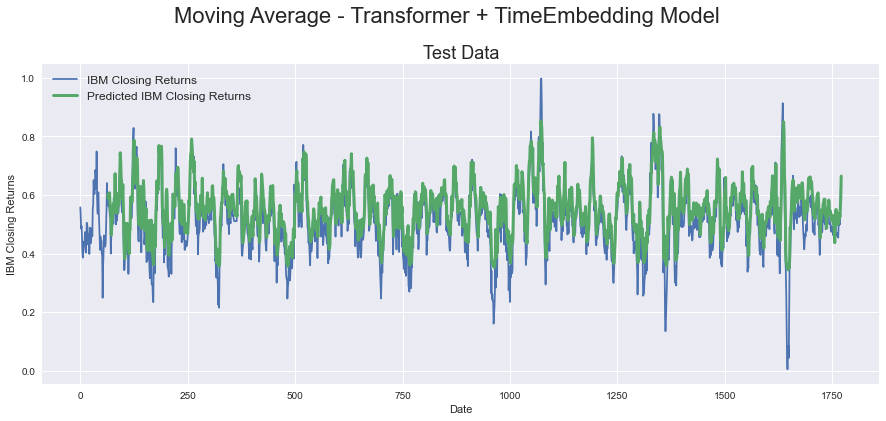

In [536]:

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)



test_pred = model.predict(X_test)
test_eval = model.evaluate(X_test, y_test, verbose=0)


fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)


#Plot test data results
ax11 = fig.add_subplot(311)
ax11.plot(test_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Test Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)



In [538]:
tendencia = test_pred[len(test_pred)-1] - test_pred[len(test_pred)-2]
print(tendencia)

[0.07454956]


In [26]:
import csv
entradaDatos = pd.read_csv('entradaDatos.csv')

Fecha = entradaDatos.Date
Open = entradaDatos.Open
High = entradaDatos.High
Low = entradaDatos.Low
Close = entradaDatos.Close
Volumen = entradaDatos.Volume


print(len(precioActual))
print(len(volumen))
print(len(fecha))

1368
1368
1368


In [154]:


dataSet = 'Test.csv'

df = pd.read_csv(dataSet, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
#df.head()


"""
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Precio Cierre AUD/USD", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
"""
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)


###############################################################################
'''Create training, validation and test split'''


df_test = df[(df.index >= 0)]

# Remove date column

df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays

test_data = df_test.values
#print('Training data shape: {}'.format(train_data.shape))
#print('Validation data shape: {}'.format(val_data.shape))
#print('Test data shape: {}'.format(test_data.shape))

#df_train.head()


###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)+1):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i-1])    #Predice el precio del cierre
X_test, y_test = np.array(X_test), np.array(y_test)



test_pred = model.predict(X_test)
test_eval = model.evaluate(X_test, y_test, verbose=0)



tendencia = test_pred[len(test_pred)-1] - test_pred[len(test_pred)-2]
tendenciaAnt = test_pred[len(test_pred)-2] - test_pred[len(test_pred)-3]
    
    
print(tendenciaAnt)
print(tendencia)
print()

valor = tendenciaAnt[0]

busqueda = mPrediccion.flat[np.abs(mPrediccion - valor).argmin()] #Busca el valor mas cercano
indice = np.where(mPrediccion == busqueda) #Busca el indice de ese valor
indice = indice[0]
indice = int(indice[0])

alcista = 0
bajista = 0
rango = 4

for i in range(indice-int(rango/2), indice+int(rango/2 +1)):
    if(i==indice):
        continue 
    else:
        if(sube[i]==1):
            alcista = alcista + 1
        elif(baja[i]==1):
            bajista = bajista + 1
        


if((sube[indice]==1 and volumen[indice]>95 and abs(valor-mPrediccion[indice]<0.00015) and (indice>200)) or alcista>=rango-1):
    print("Indice:",indice,"\t" + '\033[1m' +"SUBE" + '\033[0m')
elif((baja[indice]==1 and volumen[indice]>95 and abs(valor-mPrediccion[indice]<0.00015) and (indice>200)) or bajista>=rango-1):
    print("Indice:",indice,"\t" + '\033[1m' +"BAJA" + '\033[0m')
else:
    print("Indice:",indice,"\t" + '\033[1m' +"NO PREDECIBLE" + '\033[0m')
    


    
valor = tendencia[0]

busqueda = mPrediccion.flat[np.abs(mPrediccion - valor).argmin()] #Busca el valor mas cercano
indice = np.where(mPrediccion == busqueda) #Busca el indice de ese valor
indice = indice[0]
indice = int(indice[0])

alcista = 0
bajista = 0
rango = 4

for i in range(indice-int(rango/2), indice+int(rango/2 +1)):
    if(i==indice):
        continue 
    else:
        if(sube[i]==1):
            alcista = alcista + 1
        elif(baja[i]==1):
            bajista = bajista + 1
        
        


if((sube[indice]==1 and volumen[indice]>95 and abs(valor-mPrediccion[indice]<0.00015) and (indice>200)) or alcista>=rango-1):
    print("Indice:",indice,"\t" + '\033[1m' +"SUBE" + '\033[0m')
elif((baja[indice]==1 and volumen[indice]>95 and abs(valor-mPrediccion[indice]<0.00015) and (indice>200)) or bajista>=rango-1):
    print("Indice:",indice,"\t" + '\033[1m' +"BAJA" + '\033[0m')
else:
    print("Indice:",indice,"\t" + '\033[1m' +"NO PREDECIBLE" + '\033[0m')
    


[-0.04237282]
[0.05938309]

Indice: 165 	SUBE
Indice: 1267 	SUBE


In [115]:
print(volumen[488])
print(abs(valor-mPrediccion[indice]))

274
7.689463592530643e-06


In [75]:
# --------------------------------- Buscador de Datos -----------------------------------------
import csv
resultados = pd.read_csv('Busqueda.csv')
prediccion = resultados.TendenciaAnterior
Sube = resultados.Sube
Baja = resultados.Baja
Volumen = resultados.Volumen

print(len(resultados))
resultados.head()

1367


,TendenciaAnterior,Sube,Baja,Volumen
0,-0.249290,1,0,55
1,-0.218270,1,0,269
2,-0.190559,1,0,264
3,-0.167948,1,0,426
4,-0.161971,0,1,317


In [76]:
mPrediccion = np.array(prediccion)
sube = np.array(Sube)
baja = np.array(Baja)
volumen = np.array(Volumen)

In [77]:


valor = -0.06896427

busqueda = mPrediccion.flat[np.abs(mPrediccion - valor).argmin()] #Busca el valor mas cercano
indice = np.where(mPrediccion == busqueda) #Busca el indice de ese valor
indice = indice[0]
indice = int(indice[0])

print("Indice:",indice)
if(sube[indice]==1):
    print("SUBE")
elif(baja[indice]==1):
    print("BAJA")
else:
    print("NO PREDECIBLE")



Indice: 69
BAJA
